# Imports and program variables


In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.optimizers import Adam
from keras.utils import np_utils
from sklearn import metrics
import pandas as pd

from keras.models import Sequential
from keras.layers.recurrent import LSTM
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ReduceLROnPlateau,ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences

from time_series_dataset_loader import TimeSeriesDatasetLoader

from sklearn.model_selection import train_test_split # to split dataset into train and test
from sklearn import preprocessing

In [3]:
DATASET_PATH = '../src/Features/Original/MFCC/'

## Setting up train and test datasets

In [4]:
dataset_loader = TimeSeriesDatasetLoader(DATASET_PATH)
X, y = dataset_loader.get_dataset('emotion_type')

In [5]:
X = np.asarray(X)
y = np.asarray(y)

In [6]:
# See X and y details
print(X[0][0])
print(X.shape)

print(y[:3])
print(y.shape)

[  0.          0.         -7.33182    19.48468    -7.506955    1.82857
   5.773757  -13.56968     3.013354  -10.19034    13.51374    -1.628919
   7.978467    0.7820195   2.435657   -2.008263 ]
(1164,)
[1 0 0]
(1164,)


In [7]:
# Apply Pad Sequences
max_len = len(X[0])
for row in X:
    if len(row) > max_len:
        max_len = len(row)

X = pad_sequences(X, maxlen=max_len, padding='post')

# See X details
print(X[0][0])
print(X.shape)

[  0   0  -7  19  -7   1   5 -13   3 -10  13  -1   7   0   2  -2]
(1164, 543, 16)


In [8]:
# Split the dataset in train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\nX_test:\n")
print(X_test[0][0])
print(X_test.shape)

print("\ny_train:\n")
print(y_train[:3])
print(y_train.shape)

print("\ny_test:\n")
print(y_test[:3])
print(y_test.shape)


X_train:

[  0   0   8  -6  -6  -5   5   4   0   6  -4  11 -14  -6   1  -3]
(814, 543, 16)

X_test:

[  0   0   7   0  10   0 -10  -6  -6   1  -1 -10   8  -1   0 -11]
(350, 543, 16)

y_train:

[2 0 1]
(814,)

y_test:

[2 1 0]
(350,)


In [9]:
# Reshaping to apply smote

shape_0 = X_train.shape[0]
shape_1 = X_train.shape[1]
shape_2 = X_train.shape[2]
print(shape_0)
print(shape_1)
print(shape_2)
X_train = X_train.reshape(shape_0, shape_1 * shape_2)

print("\nX_train:\n")
print(X_train.shape)

print("\ny_train:\n")
print(y_train.shape)

814
543
16

X_train:

(814, 8688)

y_train:

(814,)


In [10]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

# Reshaping back to original shape dimensions 1 and 2
X_train = X_train.reshape(X_train.shape[0], shape_1, shape_2)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\ny_train:\n")
print(y_train[:3])
print(y_train.shape)


X_train:

[  0   0   8  -6  -6  -5   5   4   0   6  -4  11 -14  -6   1  -3]
(1392, 543, 16)

y_train:

[2 0 1]
(1392,)


In [11]:
# Create categorical matrices
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [12]:
num_rows = X[0].shape[0]
num_columns = X[0].shape[1]
num_channels = 1

X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

print("\nX_train:\n")
print(X_train[0][0])
print(X_train.shape)

print("\nX_test:\n")
print(X_test[0][0])
print(X_test.shape)


X_train:

[[  0]
 [  0]
 [  8]
 [ -6]
 [ -6]
 [ -5]
 [  5]
 [  4]
 [  0]
 [  6]
 [ -4]
 [ 11]
 [-14]
 [ -6]
 [  1]
 [ -3]]
(1392, 543, 16, 1)

X_test:

[[  0]
 [  0]
 [  7]
 [  0]
 [ 10]
 [  0]
 [-10]
 [ -6]
 [ -6]
 [  1]
 [ -1]
 [-10]
 [  8]
 [ -1]
 [  0]
 [-11]]
(350, 543, 16, 1)


## Building and Compiling Model

In [13]:
# Construct model 1
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=2, input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))
model.add(GlobalAveragePooling2D())

model.add(Dense(3, activation='softmax'))

In [14]:
# top-k category accuracy
import functools
import keras
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

# compile the keras model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy',top3_acc])

In [15]:
# Define bath and epochs
batch_size = 256
epochs = 400

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.0000001)
mcp_save = ModelCheckpoint('../models/model_checkpoints/smote_test.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, validation_data=(X_test, y_test), callbacks=[mcp_save, lr_reduce])


Train on 1392 samples, validate on 350 samples
Epoch 1/400
1392/1392 [==============================] - 10s 7ms/step - loss: 1.6452 - accuracy: 0.3333 - top3_acc: 1.0000 - val_loss: 1.2973 - val_accuracy: 0.2457 - val_top3_acc: 1.0000
Epoch 2/400
1392/1392 [==============================] - 9s 7ms/step - loss: 1.2442 - accuracy: 0.3355 - top3_acc: 1.0000 - val_loss: 1.1262 - val_accuracy: 0.2600 - val_top3_acc: 1.0000
Epoch 3/400
1392/1392 [==============================] - 9s 7ms/step - loss: 1.1776 - accuracy: 0.3290 - top3_acc: 1.0000 - val_loss: 1.1193 - val_accuracy: 0.2629 - val_top3_acc: 1.0000
Epoch 4/400
1392/1392 [==============================] - 9s 7ms/step - loss: 1.1218 - accuracy: 0.3599 - top3_acc: 1.0000 - val_loss: 1.2023 - val_accuracy: 0.2286 - val_top3_acc: 1.0000
Epoch 5/400
1392/1392 [==============================] - 9s 7ms/step - loss: 1.1161 - accuracy: 0.3527 - top3_acc: 1.0000 - val_loss: 1.0665 - val_accuracy: 0.4686 - val_top3_acc: 1.0000
Epoch 6/400
1392

1392/1392 [==============================] - 10s 7ms/step - loss: 0.9192 - accuracy: 0.5618 - top3_acc: 1.0000 - val_loss: 0.9121 - val_accuracy: 0.5743 - val_top3_acc: 1.0000
Epoch 44/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.9253 - accuracy: 0.5675 - top3_acc: 1.0000 - val_loss: 0.9084 - val_accuracy: 0.5686 - val_top3_acc: 1.0000
Epoch 45/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.9129 - accuracy: 0.5740 - top3_acc: 1.0000 - val_loss: 0.9094 - val_accuracy: 0.5600 - val_top3_acc: 1.0000
Epoch 46/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.8966 - accuracy: 0.5934 - top3_acc: 1.0000 - val_loss: 0.9069 - val_accuracy: 0.5686 - val_top3_acc: 1.0000
Epoch 47/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.9128 - accuracy: 0.5761 - top3_acc: 1.0000 - val_loss: 0.9033 - val_accuracy: 0.5714 - val_top3_acc: 1.0000
Epoch 48/400
1392/1392 [==============================] - 10s 7ms/st

1392/1392 [==============================] - 14s 10ms/step - loss: 0.7599 - accuracy: 0.6695 - top3_acc: 1.0000 - val_loss: 0.8666 - val_accuracy: 0.5857 - val_top3_acc: 1.0000
Epoch 87/400
1392/1392 [==============================] - 14s 10ms/step - loss: 0.7808 - accuracy: 0.6545 - top3_acc: 1.0000 - val_loss: 0.8665 - val_accuracy: 0.5829 - val_top3_acc: 1.0000
Epoch 88/400
1392/1392 [==============================] - 14s 10ms/step - loss: 0.7828 - accuracy: 0.6602 - top3_acc: 1.0000 - val_loss: 0.9083 - val_accuracy: 0.5371 - val_top3_acc: 1.0000
Epoch 89/400
1392/1392 [==============================] - 15s 10ms/step - loss: 0.7814 - accuracy: 0.6588 - top3_acc: 1.0000 - val_loss: 0.9259 - val_accuracy: 0.5371 - val_top3_acc: 1.0000
Epoch 90/400
1392/1392 [==============================] - 11s 8ms/step - loss: 0.7670 - accuracy: 0.6703 - top3_acc: 1.0000 - val_loss: 1.0005 - val_accuracy: 0.4914 - val_top3_acc: 1.0000
Epoch 91/400
1392/1392 [==============================] - 11s 8m

1392/1392 [==============================] - 14s 10ms/step - loss: 0.6810 - accuracy: 0.6932 - top3_acc: 1.0000 - val_loss: 0.9027 - val_accuracy: 0.5800 - val_top3_acc: 1.0000
Epoch 130/400
1392/1392 [==============================] - 14s 10ms/step - loss: 0.6736 - accuracy: 0.7069 - top3_acc: 1.0000 - val_loss: 0.9532 - val_accuracy: 0.5486 - val_top3_acc: 1.0000
Epoch 131/400
1392/1392 [==============================] - 14s 10ms/step - loss: 0.6906 - accuracy: 0.7069 - top3_acc: 1.0000 - val_loss: 0.8966 - val_accuracy: 0.5771 - val_top3_acc: 1.0000
Epoch 132/400
1392/1392 [==============================] - 14s 10ms/step - loss: 0.6747 - accuracy: 0.7019 - top3_acc: 1.0000 - val_loss: 0.8988 - val_accuracy: 0.5886 - val_top3_acc: 1.0000
Epoch 133/400
1392/1392 [==============================] - 14s 10ms/step - loss: 0.7171 - accuracy: 0.6724 - top3_acc: 1.0000 - val_loss: 0.9998 - val_accuracy: 0.4914 - val_top3_acc: 1.0000
Epoch 134/400
1392/1392 [==============================] - 

1392/1392 [==============================] - 10s 7ms/step - loss: 0.6196 - accuracy: 0.7364 - top3_acc: 1.0000 - val_loss: 0.9183 - val_accuracy: 0.5657 - val_top3_acc: 1.0000
Epoch 173/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.6212 - accuracy: 0.7356 - top3_acc: 1.0000 - val_loss: 0.8951 - val_accuracy: 0.6314 - val_top3_acc: 1.0000
Epoch 174/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.6401 - accuracy: 0.7284 - top3_acc: 1.0000 - val_loss: 0.8741 - val_accuracy: 0.6229 - val_top3_acc: 1.0000
Epoch 175/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.6174 - accuracy: 0.7522 - top3_acc: 1.0000 - val_loss: 0.8936 - val_accuracy: 0.5714 - val_top3_acc: 1.0000
Epoch 176/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.6384 - accuracy: 0.7342 - top3_acc: 1.0000 - val_loss: 0.8705 - val_accuracy: 0.5971 - val_top3_acc: 1.0000
Epoch 177/400
1392/1392 [==============================] - 10s 7

1392/1392 [==============================] - 10s 7ms/step - loss: 0.5785 - accuracy: 0.7457 - top3_acc: 1.0000 - val_loss: 0.9338 - val_accuracy: 0.6086 - val_top3_acc: 1.0000
Epoch 216/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5719 - accuracy: 0.7493 - top3_acc: 1.0000 - val_loss: 0.9425 - val_accuracy: 0.6057 - val_top3_acc: 1.0000
Epoch 217/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5545 - accuracy: 0.7658 - top3_acc: 1.0000 - val_loss: 0.9470 - val_accuracy: 0.6143 - val_top3_acc: 1.0000
Epoch 218/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5694 - accuracy: 0.7622 - top3_acc: 1.0000 - val_loss: 0.9097 - val_accuracy: 0.6086 - val_top3_acc: 1.0000
Epoch 219/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5684 - accuracy: 0.7665 - top3_acc: 1.0000 - val_loss: 0.8801 - val_accuracy: 0.6200 - val_top3_acc: 1.0000
Epoch 220/400
1392/1392 [==============================] - 10s 7

1392/1392 [==============================] - 10s 7ms/step - loss: 0.5340 - accuracy: 0.7809 - top3_acc: 1.0000 - val_loss: 0.9904 - val_accuracy: 0.6200 - val_top3_acc: 1.0000
Epoch 259/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5274 - accuracy: 0.7895 - top3_acc: 1.0000 - val_loss: 0.8936 - val_accuracy: 0.6343 - val_top3_acc: 1.0000
Epoch 260/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5424 - accuracy: 0.7759 - top3_acc: 1.0000 - val_loss: 0.8893 - val_accuracy: 0.6200 - val_top3_acc: 1.0000
Epoch 261/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5125 - accuracy: 0.7967 - top3_acc: 1.0000 - val_loss: 0.9233 - val_accuracy: 0.6314 - val_top3_acc: 1.0000
Epoch 262/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5321 - accuracy: 0.7845 - top3_acc: 1.0000 - val_loss: 0.8846 - val_accuracy: 0.6286 - val_top3_acc: 1.0000
Epoch 263/400
1392/1392 [==============================] - 10s 7

1392/1392 [==============================] - 10s 7ms/step - loss: 0.4719 - accuracy: 0.7967 - top3_acc: 1.0000 - val_loss: 0.9349 - val_accuracy: 0.6086 - val_top3_acc: 1.0000
Epoch 302/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.5091 - accuracy: 0.7989 - top3_acc: 1.0000 - val_loss: 1.0136 - val_accuracy: 0.6286 - val_top3_acc: 1.0000
Epoch 303/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4975 - accuracy: 0.7909 - top3_acc: 1.0000 - val_loss: 0.9161 - val_accuracy: 0.6400 - val_top3_acc: 1.0000
Epoch 304/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4932 - accuracy: 0.7989 - top3_acc: 1.0000 - val_loss: 0.8881 - val_accuracy: 0.6200 - val_top3_acc: 1.0000
Epoch 305/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4830 - accuracy: 0.8003 - top3_acc: 1.0000 - val_loss: 0.9352 - val_accuracy: 0.6029 - val_top3_acc: 1.0000
Epoch 306/400
1392/1392 [==============================] - 10s 7

1392/1392 [==============================] - 10s 7ms/step - loss: 0.4680 - accuracy: 0.8060 - top3_acc: 1.0000 - val_loss: 0.9693 - val_accuracy: 0.6371 - val_top3_acc: 1.0000
Epoch 345/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4713 - accuracy: 0.8161 - top3_acc: 1.0000 - val_loss: 0.9485 - val_accuracy: 0.6371 - val_top3_acc: 1.0000
Epoch 346/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4605 - accuracy: 0.8103 - top3_acc: 1.0000 - val_loss: 0.8992 - val_accuracy: 0.6143 - val_top3_acc: 1.0000
Epoch 347/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4719 - accuracy: 0.8060 - top3_acc: 1.0000 - val_loss: 0.9856 - val_accuracy: 0.6371 - val_top3_acc: 1.0000
Epoch 348/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4569 - accuracy: 0.8254 - top3_acc: 1.0000 - val_loss: 0.9269 - val_accuracy: 0.6429 - val_top3_acc: 1.0000
Epoch 349/400
1392/1392 [==============================] - 10s 7

1392/1392 [==============================] - 10s 7ms/step - loss: 0.4494 - accuracy: 0.8276 - top3_acc: 1.0000 - val_loss: 0.9665 - val_accuracy: 0.6286 - val_top3_acc: 1.0000
Epoch 388/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4241 - accuracy: 0.8362 - top3_acc: 1.0000 - val_loss: 0.9075 - val_accuracy: 0.6371 - val_top3_acc: 1.0000
Epoch 389/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4442 - accuracy: 0.8261 - top3_acc: 1.0000 - val_loss: 0.9465 - val_accuracy: 0.6086 - val_top3_acc: 1.0000
Epoch 390/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4426 - accuracy: 0.8391 - top3_acc: 1.0000 - val_loss: 0.9493 - val_accuracy: 0.6371 - val_top3_acc: 1.0000
Epoch 391/400
1392/1392 [==============================] - 10s 7ms/step - loss: 0.4502 - accuracy: 0.8218 - top3_acc: 1.0000 - val_loss: 0.9342 - val_accuracy: 0.6343 - val_top3_acc: 1.0000
Epoch 392/400
1392/1392 [==============================] - 10s 7

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 542, 15, 32)       160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 271, 7, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 271, 7, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 270, 6, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 135, 3, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 135, 3, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 134, 2, 128)      

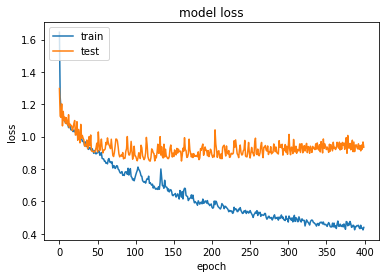

In [17]:
import matplotlib.pyplot as plt

# Model Summary

model.summary()

# PLT History info
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()